# Re-creating [Capillary Hysteresis in Neutrally Wettable Fibrous Media: A Pore Network Study of a Fuel Cell Electrode](http://link.springer.com/10.1007/s11242-017-0973-2)
# Part A: Percolation

## Introduction

In this tutorial, we will use the ```MixedInvasionPercolation``` algorithm to examine capillary hysteresis in a fibrous media with neutral wettability to water and air as detailed in [Tranter et al. 2017](http://link.springer.com/10.1007/s11242-017-0973-2). Part (a) performs the percolation simulation, part (b) uses the output of part (a) and computes relative diffusivity and part (c) takes a deeper look into the meniscus model.

The paper reproduces data gathered by [Gostick et al. 2009](https://www.sciencedirect.com/science/article/abs/pii/S0378775309007381) for the Toray 090 carbon fiber paper commonly used as a gas diffusion layer (GDL) in Polymer Electrolyte Fuel Cells (PEFCs). Fuel cells are electrochemical devices that convert hydrogen and oxygen into water as part of a redox reaction involving two half-steps. At the anode hydrogen oxidizes into protons and electrons, the protons migrate through a semi-permeable polymer membrane with a water content dependent conductivity. The electrons flow in the opposite direction, around an external cicuit producing work and recombine with the protons and oxygen in the cathode to form water. The reactants are both in gaseous form and the product water will typically saturate the cell and must be managed, keeping the membrane hydrated but not flooding the cell completley leading to blocking of reactant gases. The GDL is therefore an important component in the cell operation as it helps to remove water and aids diffusion to regions of the cell which may become starved of reactant. Understanding of the capillary properties of the GDL for multiphase transport is therefore essential for improving and maintaining fuel cell operation.

![](https://media.giphy.com/media/13HsQGjr68hH3y/giphy.gif)

The experimental data shows a strong hysteresis in the capillary pressure defined as $P_c = P_{water} - P_{air}$. Whereby, on injecting water into an air-filled GDL, positive capillary pressure is required, whereas negative capillary pressure is required to withdraw the water. This signifies that the material is neither wetting to water nor air and was previously explained by contact angle hysteresis. However, by considering the shape of the interface as it moves in-between fibers a more logical explanation can be found. The constrictions between fibers are modelled as toroidal or donut shaped, as first explained by [Purcell](https://www.onepetro.org/journal-paper/SPE-950369-G). With changing capillary pressure, as the mensicus contact line moves it conforms to the converging and diverging geometry and this modifies the effective contact angle. An inflection always occurs, irrespective of the intrinsic contact angle, signifying a change in pressure from negative to positive in the invading phase.

The invasion mechanism in highly porous fibrous media is complex and considering invasion of a single throat in isolation is not appropriate. The entry pressure in the simple isolated case is just the maximum pressure experienced by the meniscus as it transitions through the throat: termed burst pressure. However, the model allows for the bulge of the mensiscus to protrude quite far into the neighboring pore before the burst pressure is exceeded. The model is used in a new ```meniscus``` class of OpenPNM which supplies information about the position, size and shape of the mensicus at a given capillary pressure. These details are used by the ```MixedInvasionPercolation``` class to determine which type of invasion event may occur as it is now possible to determine whether an individual meniscus inside a throat will interact with solid features in neighboring pores (touch pressure) or even neighboring meniscii (cooperative pore filling). As nearby mensicii may grow simulataneously, they may coalesce at much lower pressure than the burst pressure, thus changing the characteristic capillary behaviour and saturation profile within the material. 

The network is generated using the ```VoronoiFibers``` class, for which there is a tutorial in the topology folder. For speed and convenience we provide a pickled dictionary with the network properties because the domain is quite large and would take 30 mins to generate from scratch.

## Model Setup

First we import the required python modules and load the network file

In [1]:
import openpnm as op
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from openpnm.models import physics as pm
%matplotlib inline
wrk = op.Workspace()
wrk.loglevel=50
wrk.clear()

path = Path('../fixtures/hysteresis_paper_network.p')
save_net = pickle.load(open(path, "rb"))
prj = op.Project(name='hysteresis_paper')
pn = op.network.GenericNetwork(project=prj, name='network')
pn.update(save_net)
print(pn.Np, pn.Nt)

2854 10215


Now we set some key variables for the simulation, $\theta$ is the contact angle in each phase and without contact hysteresis sums to 180. The fiber radius is 5 $\mu m$ for this particular material and this used in the pore-scale capillary pressure models.

In [2]:
theta_w = 110
theta_a = 70
fiber_rad = 5e-6

## Experimental Data

The experimental data we are matching is taken from the 2009 paper for uncompressed Toray 090D which has had some treatment with PTFE to make it non-wetting to water. However, the material also seems to be non-wetting to air, once filled with water as reducing the pressure once invaded with water does not lead to spontaneous uptake of air.

In [3]:
data = np.array([[-1.95351934e+04,  0.00000000e+00], [-1.79098945e+04,  1.43308300e-03], [-1.63107500e+04,  1.19626000e-03],
                 [-1.45700654e+04,  9.59437000e-04], [-1.30020859e+04,  7.22614000e-04], [-1.14239746e+04,  4.85791000e-04],
                 [-9.90715234e+03,  2.48968000e-04], [-8.45271973e+03,  1.68205100e-03], [-7.01874170e+03,  1.44522800e-03],
                 [-5.61586768e+03,  2.87831100e-03], [-4.27481055e+03,  4.44633600e-03], [-3.52959229e+03,  5.81363400e-03],
                 [-2.89486523e+03,  5.51102700e-03], [-2.25253784e+03,  8.26249200e-03], [-1.59332751e+03,  9.32718400e-03],
                 [-9.93971252e+02,  1.03918750e-02], [-3.52508118e+02,  1.31433410e-02], [ 2.55833755e+02,  1.90500850e-02],
                 [ 8.10946533e+02,  1.12153247e-01], [ 1.44181152e+03,  1.44055799e-01], [ 2.02831689e+03,  1.58485811e-01],
                 [ 2.56954688e+03,  1.68051842e-01], [ 3.22414917e+03,  1.83406543e-01], [ 3.81607397e+03,  2.00111675e-01],
                 [ 4.35119043e+03,  2.20173487e-01], [ 4.93044141e+03,  2.50698356e-01], [ 5.44759180e+03,  2.70760168e-01],
                 [ 5.97326611e+03,  3.02663131e-01], [ 6.49410010e+03,  3.83319515e-01], [ 7.05238232e+03,  5.06499276e-01],
                 [ 7.54107031e+03,  6.63817501e-01], [ 8.08143408e+03,  7.67864788e-01], [ 8.54633203e+03,  8.26789866e-01],
                 [ 9.03138965e+03,  8.62470191e-01], [ 9.53165723e+03,  8.84504516e-01], [ 1.00119375e+04,  9.01529123e-01],
                 [ 1.19394492e+04,  9.32130571e-01], [ 1.37455771e+04,  9.43415425e-01], [ 1.54468594e+04,  9.54111932e-01],
                 [ 1.71077578e+04,  9.59966386e-01], [ 1.87670996e+04,  9.66241521e-01], [ 2.02733223e+04,  9.70728677e-01],
                 [ 2.17321895e+04,  9.75215832e-01], [ 2.30644336e+04,  9.79820651e-01], [ 2.44692598e+04,  9.81254145e-01],
                 [ 2.56992520e+04,  9.88778094e-01], [ 2.69585078e+04,  9.93080716e-01], [ 2.81848105e+04,  9.92843893e-01],
                 [ 2.93189434e+04,  9.99000955e-01], [ 3.04701816e+04,  1.00180134e+00], [ 2.94237266e+04,  1.00323442e+00],
                 [ 2.82839531e+04,  1.00132769e+00], [ 2.70130059e+04,  1.00109128e+00], [ 2.57425723e+04,  1.00085404e+00],
                 [ 2.43311738e+04,  1.00047148e+00], [ 2.29761172e+04,  1.00023466e+00], [ 2.15129902e+04,  9.99997838e-01],
                 [ 2.00926621e+04,  9.98091109e-01], [ 1.85019902e+04,  9.97854286e-01], [ 1.70299883e+04,  9.95947557e-01],
                 [ 1.53611387e+04,  9.95710734e-01], [ 1.36047275e+04,  9.93804005e-01], [ 1.18231387e+04,  9.93567182e-01],
                 [ 9.87990430e+03,  9.91660453e-01], [ 9.40066016e+03,  9.89671072e-01], [ 8.89503516e+03,  9.89368465e-01],
                 [ 8.39770508e+03,  9.89065857e-01], [ 7.89161768e+03,  9.88763250e-01], [ 7.37182080e+03,  9.86790737e-01],
                 [ 6.87028369e+03,  9.86488130e-01], [ 6.28498584e+03,  9.85882915e-01], [ 5.80695361e+03,  9.85580308e-01],
                 [ 5.23104834e+03,  9.85277701e-01], [ 4.68521338e+03,  9.84975094e-01], [ 4.11333887e+03,  9.84672487e-01],
                 [ 3.59290625e+03,  9.84369879e-01], [ 2.96803101e+03,  9.84067272e-01], [ 2.41424536e+03,  9.82094759e-01],
                 [ 1.82232153e+03,  9.81792152e-01], [ 1.22446594e+03,  9.79819639e-01], [ 6.63709351e+02,  9.79517032e-01],
                 [ 7.13815610e+01,  9.79214424e-01], [-5.23247498e+02,  9.75437063e-01], [-1.19633813e+03,  9.73464550e-01],
                 [-1.81142188e+03,  9.66162844e-01], [-2.46475146e+03,  9.42637411e-01], [-3.08150562e+03,  8.98736764e-01],
                 [-3.72976978e+03,  7.06808493e-01], [-4.36241846e+03,  3.18811069e-01], [-5.10291357e+03,  2.13867093e-01],
                 [-5.77698242e+03,  1.76544863e-01], [-6.47121728e+03,  1.62546665e-01], [-7.23913574e+03,  1.49192478e-01],
                 [-7.89862988e+03,  1.45550059e-01], [-8.60248633e+03,  1.43577546e-01], [-9.35398340e+03,  1.39800185e-01],
                 [-1.00623330e+04,  1.37827671e-01], [-1.15617539e+04,  1.37590848e-01], [-1.31559434e+04,  1.37354025e-01],
                 [-1.48024961e+04,  1.35430429e-01], [-1.63463340e+04,  1.33523700e-01], [-1.80782656e+04,  1.33286877e-01],
                 [-1.98250000e+04,  1.31380148e-01], [-2.15848105e+04,  1.31143325e-01], [-2.34678457e+04,  1.29236596e-01]])

Text(0,0.5,'Saturation \n Porous Volume Fraction occupied by water')

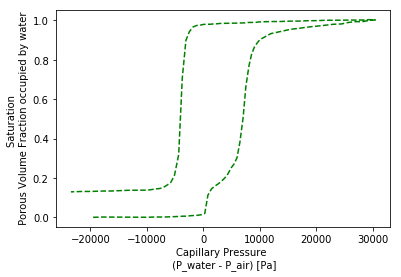

In [4]:
plt.figure()
plt.plot(data[:, 0], data[:, 1], 'g--')
plt.xlabel('Capillary Pressure \n (P_water - P_air) [Pa]')
plt.ylabel('Saturation \n Porous Volume Fraction occupied by water')

## New Geometric Parameters

The following code block cleans up the data a bit. The ```conduit_lengths``` are a new addition to openpnm to be able to apply different conductances along the length of the conduit for each section. Conduits in OpenPNM are considered to be comprised of a throat and the two half-pores either side and the length of each element is somewhat subjective for a converging, diverging profile such as a sphere pack or indeed fibrous media such as the GDL. We will effectively apply the conductance of the throat to the entire conduit length by setting the pore sections to be very small. For these highly porous materials the cross-sectional area of a throat is similar to that of the pore and so this is a reasonable assumption. It also helps to account for anisotropy of the material as the throats have vectors whereas pores do not.

Boundary pores also need to be handled with care. These are placed on the faces of the domain and have zero volume but need other properties for the conductance models to work. They are mainly used for defining the inlets and outlets of the percolation simulations and effective transport simulations. However, they are kind of fictitious so we do not want them contributing resistance to flow and therefore set their areas to be the highest in the network. The boundary pores are aligned with the planar faces of the domain, which is necessary for the effective transport property calculations which consider the transport through an effective medium of defined size and shape. 

In [5]:
net_health = pn.check_network_health()
if len(net_health['trim_pores']) > 0:
    op.topotools.trim(network=pn, pores=net_health['trim_pores'])

Ps = pn.pores()
Ts = pn.throats()
geom = op.geometry.GenericGeometry(network=pn, pores=Ps, throats=Ts, name='geometry')
geom['throat.conduit_lengths.pore1'] = 1e-12
geom['throat.conduit_lengths.pore2'] = 1e-12
geom['throat.conduit_lengths.throat'] = geom['throat.length'] - 2e-12

# Handle Boundary Pores - Zero Volume for saturation but not zero diam and area
# For flow calculations
pn['pore.diameter'][pn['pore.diameter'] == 0.0] = pn['pore.diameter'].max()
pn['pore.area'][pn['pore.area'] == 0.0] = pn['pore.area'].max()

## Phase Setup

Now we set up the phases and apply the contact angles.

In [6]:
air = op.phases.Air(network=pn, name='air')
water = op.phases.Water(network=pn, name='water')
air['pore.contact_angle'] = theta_a
air["pore.surface_tension"] = water["pore.surface_tension"]
water['pore.contact_angle'] = theta_w
water["pore.temperature"] = 293.7
water.regenerate_models()

## Physics Setup

Now we set up the physics for each phase. The default capillary pressure model from the ```Standard physics``` class is the Washburn model which applies to straight capillary tubes and we must override it here with the Purcell model. We add the model to both phases and also add a value for pore.entry_pressure making sure that it is less than any of the throat.entry_pressure values. This is done because the ```MixedInvasionPercolation``` model invades pores and throats separately and for now we just want to consider the pores to be invaded as soon as their connecting throats are.

In [7]:
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geom, name='phys_air')
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geom, name='phys_water')
throat_diam = 'throat.diameter'
pore_diam = 'pore.indiameter'

pmod = pm.capillary_pressure.purcell
phys_water.add_model(propname='throat.entry_pressure',
                     model=pmod,
                     r_toroid=fiber_rad,
                     diameter=throat_diam)
phys_air.add_model(propname='throat.entry_pressure',
                   model=pmod,
                   r_toroid=fiber_rad,
                   diameter=throat_diam)

# Ignore the pore entry pressures
phys_air['pore.entry_pressure'] = -999999
phys_water['pore.entry_pressure'] = -999999

print("Mean Water Throat Pc:",str(np.mean(phys_water["throat.entry_pressure"])))
print("Mean Air Throat Pc:",str(np.mean(phys_air["throat.entry_pressure"])))

Mean Water Throat Pc: 14763.892527782806
Mean Air Throat Pc: 9939.338856117427


We apply the following late pore filling model:
$ S_{res} = S_{wp}^*\left(\frac{P_c^*}{P_c}\right)^{\eta}$
This is a heuristic model that adjusts the phase ocupancy inside an individual after is has been invaded and reproduces the gradual expansion of the phases into smaller sub-pore scale features such as cracks fiber intersections.

In [8]:
lpf = 'pore.late_filling'
phys_water.add_model(propname='pore.pc_star',
                     model=op.models.misc.from_neighbor_throats,
                     throat_prop='throat.entry_pressure',
                     mode='min')
phys_water.add_model(propname=lpf,
                     model=pm.multiphase.late_filling,
                     pressure='pore.pressure',
                     Pc_star='pore.pc_star',
                     Swp_star=0.25,
                     eta=2.5)

Finally we add the meniscus model for cooperative pore filling. The model mechanics are explained in greater detail in part c of this tutorial but the process is shown in the animation below. The brown fibrous cage structure represents the fibers surrounding and defining a single pore in the network. The shrinking spheres represent the invading phase present at each throat. The cooperative pore filling sequence for a single pore in the network then goes as follow: As pressure increases the phase is squeezed futher into the pores and the curvature of each meniscus increases. If there are no meniscii overlapping inside the pore they are coloured blue and when menisci spheres begin to intersect (inside the pore) they are coloured green. When the spheres curvature reaches the maximum required to transition through the throats they are coloured red. Larger throats allows for smaller curvature and lower pressure. Not all spheres transition from blue to green before going red and represent a burst before coalescence regardless of phase occupancy. Meniscii interactions are assessed for every throat and all the neighboring throats for each pore as a pre-processing step to determine the coalsecence pressure. Then once the percolation algorithm is running the coalescence is triggered if the phase is present at the corresponding throat pairs and the coalescence pressure is lower than the burst pressure.

In [9]:
phys_air.add_model(propname='throat.meniscus',
                   model=op.models.physics.meniscus.toroidal,
                   mode='men',
                   r_toroid=fiber_rad,
                   target_Pc=5000)

![](https://media.giphy.com/media/4T92oO1cd0mzYm24gv/giphy.gif)

## Percolation Algorithms

Now all the physics is defined we can setup and run two algorithms for water injection and withdrawal and compare to the experimental data.

Text(0,0.5,'Saturation \n Porous Volume Fraction occupied by water')

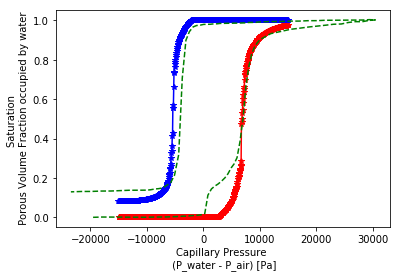

In [10]:
inv_points = np.arange(-15000, 15100, 50)

IP_injection = op.algorithms.MixedInvasionPercolation(network=pn, name='injection')
IP_injection.setup(phase=water)
IP_injection.set_inlets(pores=pn.pores('bottom_boundary'))
IP_injection.settings['late_pore_filling'] = 'pore.late_filling'
IP_injection.run()
injection_data = IP_injection.get_intrusion_data(inv_points=inv_points)

IP_withdrawal = op.algorithms.MixedInvasionPercolation(network=pn, name='withdrawal')
IP_withdrawal.setup(phase=air)
IP_withdrawal.set_inlets(pores=pn.pores('top_boundary'))
IP_withdrawal.setup(cooperative_pore_filling='throat.meniscus')
coop_points = np.arange(0, 1, 0.01)*inv_points.max()
IP_withdrawal.setup_coop_filling(inv_points=coop_points)
IP_withdrawal.run()
IP_withdrawal.set_outlets(pores=pn.pores(['bottom_boundary']))
IP_withdrawal.apply_trapping()
withdrawal_data = IP_withdrawal.get_intrusion_data(inv_points=inv_points)

plt.figure()
plt.plot(injection_data.Pcap, injection_data.S_tot, 'r*-')
plt.plot(-withdrawal_data.Pcap, 1-withdrawal_data.S_tot, 'b*-')
plt.plot(data[:, 0], data[:, 1], 'g--')
plt.xlabel('Capillary Pressure \n (P_water - P_air) [Pa]')
plt.ylabel('Saturation \n Porous Volume Fraction occupied by water')

## Saving the output

OpenPNM manages the simulation projects with the ```Workspace``` manager class which is a singleton and instantied when OpenPNM is first imported. We can print it to take a look at the contents

In [11]:
print(wrk)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
OpenPNM Version 2.0.2 Workspace
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 hysteresis_paper
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 Object Name     Object ID                                                        
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 network         <openpnm.network.GenericNetwork object at 0x17027ca0678>         
 geometry        <openpnm.geometry.GenericGeometry object at 0x17027a66888>       
 air             <openpnm.phases.Air object at 0x1702d411b48>                     
 water           <openpnm.phases.Water object at 0x1700e4f4c50>                   
 phys_air        <openpnm.physics.Standard object at 0x1702d4111a8>               
 phys_water      <openpnm.physics.Standard object at 0x1702d411f68>               
 injection       <openpnm.algorithms.MixedInvasionPer

The project is saved for part b of this tutorial

In [12]:
wrk.save_project(prj, '../fixtures/hysteresis_paper_project')